In [2]:
# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from OA_utils.data_utils import *
from OA_utils.eval_utils import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from OA_lstm import LSTMModel
from OA_cnnlstm import CNNLSTMModel
from OA_lstmattn import LSTMAttentionModel
from OA_transformer import TransformerModel

In [3]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [4]:
data_dir = "C:\\Users\\bakel\\Downloads\\"

test_data = np.load(data_dir + 'OA_test_data.npz')

grf_labels = ['GRF_x', 'GRF_y', 'GRF_z']
muscle_labels = ['tibpost', 'tibant', 'edl', 'ehl', 
                 'fdl', 'fhl', 'perbrev', 'perlong', 'achilles']
muscle_titles = ['Tibialis Posterior', 'Tibialis Anterior', 'Extensor Digitorum Longus', 'Extensor Hallucis Longus', 
                 'Flexor Digitorum Longus', 'Flexor Hallucis Longus', 'Peroneus Brevis', 'Peroneus Longus', 'Achilles']
muscle_abbrevs = ['Tib Post', 'Tib Ant', 'EDL', 'EHL', 'FDL', 'FHL', 'Per Brevis', 'Per Long', 'Achilles']

grf_dict = {0: 'GRF_x', 1: 'GRF_y', 2: 'GRF_z'}
muscle_dict = {0: 'tibpost', 1: 'tibant', 2: 'edl', 3: 'ehl', 4: 'fdl', 5: 'fhl', 6: 'perbrev', 7: 'perlong', 8: 'achilles'}

In [5]:
X_test = test_data['X_test']
y_test = test_data['y_test']

print(X_test.shape, y_test.shape)

(843, 100, 3) (843, 100, 9)


In [6]:
# convert test data to torch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [14]:
lstm_model = LSTMModel(input_size=3, 
                       hidden_size=256, 
                       num_layers=3, 
                       output_size=9, 
                       dropout=0.2673203561889991)

lstm_model.load_state_dict(torch.load('../models/OA_lstm.pth', weights_only=True))

lstm_model.to(device)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(lstm_model.parameters(), 
#                        lr=0.0004070688993179255, 
#                        weight_decay=4.278679617413207e-05)

LSTMModel(
  (lstm): LSTM(3, 256, num_layers=3, batch_first=True, dropout=0.2673203561889991)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [15]:
lstm_loss, lstm_pred_tensor = eval_model(lstm_model, X_test_tensor, y_test_tensor)
print(f"LSTM Loss: {lstm_loss}")

LSTM Loss: 9702.4150390625


In [16]:
# y_test = y_test_tensor.cpu().numpy()
lstm_pred = lstm_pred_tensor.cpu().numpy()

lstm_rrmse = calc_rrmse_muscle(y_test, lstm_pred)

tibpost: 0.0849
tibant: 0.0726
edl: 0.0755
ehl: 0.0203
fdl: 0.0255
fhl: 0.0405
perbrev: 0.0801
perlong: 0.0623
achilles: 0.0420


In [17]:
lstm_mae = calc_mae_muscle(y_test, lstm_pred)

tibpost: 77.5205
tibant: 51.2752
edl: 12.9287
ehl: 2.5338
fdl: 4.0663
fhl: 17.8137
perbrev: 11.1993
perlong: 38.2876
achilles: 155.7146


In [18]:
lstm_r2 = calc_r2_muscle(y_test, lstm_pred)

tibpost: 0.3481
tibant: 0.4583
edl: 0.2813
ehl: 0.2267
fdl: 0.3067
fhl: 0.2527
perbrev: 0.4309
perlong: 0.3474
achilles: 0.8953


In [19]:
cnnlstm_model = CNNLSTMModel(input_size=3, 
                             hidden_size=256,
                             num_layers=2, 
                             output_size=9, 
                             dropout=0.4140734044260427)

cnnlstm_model.load_state_dict(torch.load('../models/OA_cnn-lstm.pth', weights_only=True))

cnnlstm_model.to(device)

CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.4140734044260427)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [20]:
cnnlstm_loss, cnnlstm_pred_tensor = eval_model(cnnlstm_model, X_test_tensor, y_test_tensor)
print(f"CNN-LSTM Loss: {cnnlstm_loss}")

CNN-LSTM Loss: 16250.3583984375


In [21]:
# y_test = y_test_tensor.cpu().numpy()
cnnlstm_pred = cnnlstm_pred_tensor.cpu().numpy()

cnnlstm_rrmse = calc_rrmse_muscle(y_test, cnnlstm_pred)

tibpost: 0.0923
tibant: 0.0713
edl: 0.0757
ehl: 0.0201
fdl: 0.0277
fhl: 0.0435
perbrev: 0.0832
perlong: 0.0647
achilles: 0.0577


In [22]:
cnnlstm_mae = calc_mae_muscle(y_test, cnnlstm_pred)

tibpost: 83.0987
tibant: 49.1259
edl: 12.4366
ehl: 2.1844
fdl: 4.4398
fhl: 19.0345
perbrev: 11.4015
perlong: 39.2522
achilles: 242.6801


In [23]:
cnnlstm_r2 = calc_r2_muscle(y_test, cnnlstm_pred)

tibpost: 0.2302
tibant: 0.4777
edl: 0.2778
ehl: 0.2412
fdl: 0.1851
fhl: 0.1354
perbrev: 0.3851
perlong: 0.2946
achilles: 0.8023


In [27]:
lstmattn_model = LSTMAttentionModel(input_size=3, 
                                    hidden_size=128, 
                                    num_layers=3, 
                                    num_heads=8, 
                                    output_size=9, 
                                    lstm_dropout=0.3300940727097184, 
                                    attn_dropout=0.4834824525722158)

lstmattn_model.load_state_dict(torch.load('../models/OA_lstm-attn.pth', weights_only=True))

lstmattn_model.to(device)

LSTMAttentionModel(
  (lstm): LSTM(3, 128, num_layers=3, batch_first=True, dropout=0.3300940727097184)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=9, bias=True)
)

In [28]:
lstmattn_loss, lstmattn_pred_tensor = eval_model(lstmattn_model, X_test_tensor, y_test_tensor)
print(f"LSTM-Attention Loss: {lstmattn_loss}")

LSTM-Attention Loss: 5402.66552734375


In [29]:
lstmattn_pred = lstmattn_pred_tensor.cpu().numpy()

lstmattn_rrmse = calc_rrmse_muscle(y_test, lstmattn_pred)

tibpost: 0.0758
tibant: 0.0700
edl: 0.0808
ehl: 0.0213
fdl: 0.0245
fhl: 0.0390
perbrev: 0.0831
perlong: 0.0627
achilles: 0.0277


In [30]:
lstmattn_mae = calc_mae_muscle(y_test, lstmattn_pred)

tibpost: 71.2224
tibant: 49.6873
edl: 13.9338
ehl: 2.6778
fdl: 3.8309
fhl: 18.5858
perbrev: 11.9638
perlong: 41.5939
achilles: 109.7095


In [31]:
lstmattn_r2= calc_r2_muscle(y_test, lstmattn_pred)

tibpost: 0.4804
tibant: 0.4960
edl: 0.1764
ehl: 0.1531
fdl: 0.3611
fhl: 0.3038
perbrev: 0.3875
perlong: 0.3382
achilles: 0.9545


In [33]:
transformer_model = TransformerModel(input_dim=3,
                                     output_dim=9, 
                                     d_model=64, 
                                     nhead=8, 
                                     num_encoder_layers=6, 
                                     dim_feedforward=128, 
                                     dropout=0.01607138585389776)

transformer_model.load_state_dict(torch.load('../models/OA_transformer.pth', weights_only=True))

transformer_model.to(device)

TransformerModel(
  (input_embedding): Linear(in_features=3, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.01607138585389776, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.01607138585389776, inplace=False)
        (dropout2): Dropout(p=0.01607138585389776, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=64, out_features=9, bias=True)
)

In [34]:
transformer_loss, transformer_pred_tensor = eval_model(transformer_model, X_test_tensor, y_test_tensor)
print(f"Transformer Loss: {transformer_loss}")

Transformer Loss: 4362.22265625


In [35]:
transformer_pred = transformer_pred_tensor.cpu().numpy()

transformer_rrmse = calc_rrmse_muscle(y_test, transformer_pred)

tibpost: 0.0541
tibant: 0.0560
edl: 0.0680
ehl: 0.0187
fdl: 0.0199
fhl: 0.0286
perbrev: 0.0635
perlong: 0.0489
achilles: 0.0274


In [36]:
transformer_mae = calc_mae_muscle(y_test, transformer_pred)

tibpost: 45.0374
tibant: 36.9135
edl: 12.5156
ehl: 2.1432
fdl: 2.8787
fhl: 10.7538
perbrev: 9.1759
perlong: 31.7653
achilles: 93.3347


In [37]:
transformer_r2 = calc_r2_muscle(y_test, transformer_pred)

tibpost: 0.7350
tibant: 0.6774
edl: 0.4167
ehl: 0.3424
fdl: 0.5774
fhl: 0.6259
perbrev: 0.6423
perlong: 0.5981
achilles: 0.9553


In [38]:
lstm_rmse_overall = calc_rmse_overall(y_test, lstm_pred)
print(f"LSTM RMSE Overall: {lstm_rmse_overall}")

cnnlstm_rmse_overall = calc_rmse_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM RMSE Overall: {cnnlstm_rmse_overall}")

lstmattn_rmse_overall = calc_rmse_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention RMSE Overall: {lstmattn_rmse_overall}")

transformer_rmse_overall = calc_rmse_overall(y_test, transformer_pred)
print(f"Transformer RMSE Overall: {transformer_rmse_overall}")

LSTM RMSE Overall: 98.50083507796248
CNN-LSTM RMSE Overall: 127.4768889006407
LSTM-Attention RMSE Overall: 73.50282830465797
Transformer RMSE Overall: 66.04712236785817


In [39]:
lstm_rrmse_overall = calc_rrmse_overall(y_test, lstm_pred)
print(f"LSTM RRMSE Overall: {lstm_rrmse_overall}")

cnnlstm_rrmse_overall = calc_rrmse_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM RRMSE Overall: {cnnlstm_rrmse_overall}")

lstmattn_rrmse_overall = calc_rrmse_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention RRMSE Overall: {lstmattn_rrmse_overall}")

transformer_rrmse_overall = calc_rrmse_overall(y_test, transformer_pred)
print(f"Transformer RRMSE Overall: {transformer_rrmse_overall}")

LSTM RRMSE Overall: 0.016341856767683727
CNN-LSTM RRMSE Overall: 0.021149151252934675
LSTM-Attention RRMSE Overall: 0.012194543236345693
Transformer RRMSE Overall: 0.0109575986112091


In [40]:
lstm_rrmse_weighted = calc_rrmse_weighted(y_test, lstm_pred)
print(f"LSTM RRMSE Weighted: {lstm_rrmse_weighted}")

cnnlstm_rrmse_weighted = calc_rrmse_weighted(y_test, cnnlstm_pred)
print(f"CNN-LSTM RRMSE Weighted: {cnnlstm_rrmse_weighted}")

lstmattn_rrmse_weighted = calc_rrmse_weighted(y_test, lstmattn_pred)
print(f"LSTM-Attention RRMSE Weighted: {lstmattn_rrmse_weighted}")

transformer_rrmse_weighted = calc_rrmse_weighted(y_test, transformer_pred)
print(f"Transformer RRMSE Weighted: {transformer_rrmse_weighted}")

LSTM RRMSE Weighted: 0.0523950096975681
CNN-LSTM RRMSE Weighted: 0.06212210428164849
LSTM-Attention RRMSE Weighted: 0.043516357637093855
Transformer RRMSE Weighted: 0.036761335226840997


In [41]:
lstm_rmspe = calc_rmspe_overall(y_test, lstm_pred)
print(f"LSTM RMSPE: {lstm_rmspe}")

cnnlstm_rmspe = calc_rmspe_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM RMSPE: {cnnlstm_rmspe}")

lstmattn_rmspe = calc_rmspe_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention RMSPE: {lstmattn_rmspe}")

transformer_rmspe = calc_rmspe_overall(y_test, transformer_pred)
print(f"Transformer RMSPE: {transformer_rmspe}")

LSTM RMSPE: 1.2519554248218037
CNN-LSTM RMSPE: 1.1961408128100222
LSTM-Attention RMSPE: 1.2310641634396908
Transformer RMSPE: 1.0201832797540107


In [42]:
lstm_mae_overall = calc_mae_overall(y_test, lstm_pred)
print(f"LSTM MAE Overall: {lstm_mae_overall}")

cnnlstm_mae_overall = calc_mae_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM MAE Overall: {cnnlstm_mae_overall}")

lstmattn_mae_overall = calc_mae_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention MAE Overall: {lstmattn_mae_overall}")

transformer_mae_overall = calc_mae_overall(y_test, transformer_pred)
print(f"Transformer MAE Overall: {transformer_mae_overall}")

LSTM MAE Overall: 41.2599678304142
CNN-LSTM MAE Overall: 51.51708656521913
LSTM-Attention MAE Overall: 35.911686086764355
Transformer MAE Overall: 27.168679131061857


In [43]:
lstm_mae_weighted = calc_mae_weighted(y_test, lstm_pred)
print(f"LSTM MAE Weighted: {lstm_mae_weighted}")

cnnlstm_mae_weighted = calc_mae_weighted(y_test, cnnlstm_pred)
print(f"CNN-LSTM MAE Weighted: {cnnlstm_mae_weighted}")

lstmattn_mae_weighted = calc_mae_weighted(y_test, lstmattn_pred)
print(f"LSTM-Attention MAE Weighted: {lstmattn_mae_weighted}")

transformer_mae_weighted = calc_mae_weighted(y_test, transformer_pred)
print(f"Transformer MAE Weighted: {transformer_mae_weighted}")

LSTM MAE Weighted: 0.03344125370284449
CNN-LSTM MAE Weighted: 0.041754660811658774
LSTM-Attention MAE Weighted: 0.0291064648974146
Transformer MAE Weighted: 0.022020247212196944


In [44]:
lstm_r2_overall = calc_r2_overall(y_test, lstm_pred)
print(f"LSTM R2: {lstm_r2_overall}")

cnnlstm_r2_overall = calc_r2_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM R2: {cnnlstm_r2_overall}")

lstmattn_r2_overall = calc_r2_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention R2: {lstmattn_r2_overall}")

transformer_r2_overall = calc_r2_overall(y_test, transformer_pred)
print(f"Transformer R2: {transformer_r2_overall}")

LSTM R2: 0.9347330553220448
CNN-LSTM R2: 0.8906858531545979
LSTM-Attention R2: 0.9636569343184728
Transformer R2: 0.9706558686013687


In [45]:
from sklearn.metrics import r2_score

lstm_r2_overall = r2_score(y_test.flatten(), lstm_pred.flatten())
print(f"LSTM R2: {lstm_r2_overall}")

cnnlstm_r2_overall = r2_score(y_test.flatten(), cnnlstm_pred.flatten())
print(f"CNN-LSTM R2: {cnnlstm_r2_overall}")

lstmattn_r2_overall = r2_score(y_test.flatten(), lstmattn_pred.flatten())
print(f"LSTM-Attention R2: {lstmattn_r2_overall}")

transformer_r2_overall = r2_score(y_test.flatten(), transformer_pred.flatten())
print(f"Transformer R2: {transformer_r2_overall}")

LSTM R2: 0.9347330553220448
CNN-LSTM R2: 0.8906858531545979
LSTM-Attention R2: 0.9636569343184728
Transformer R2: 0.9706558686013687


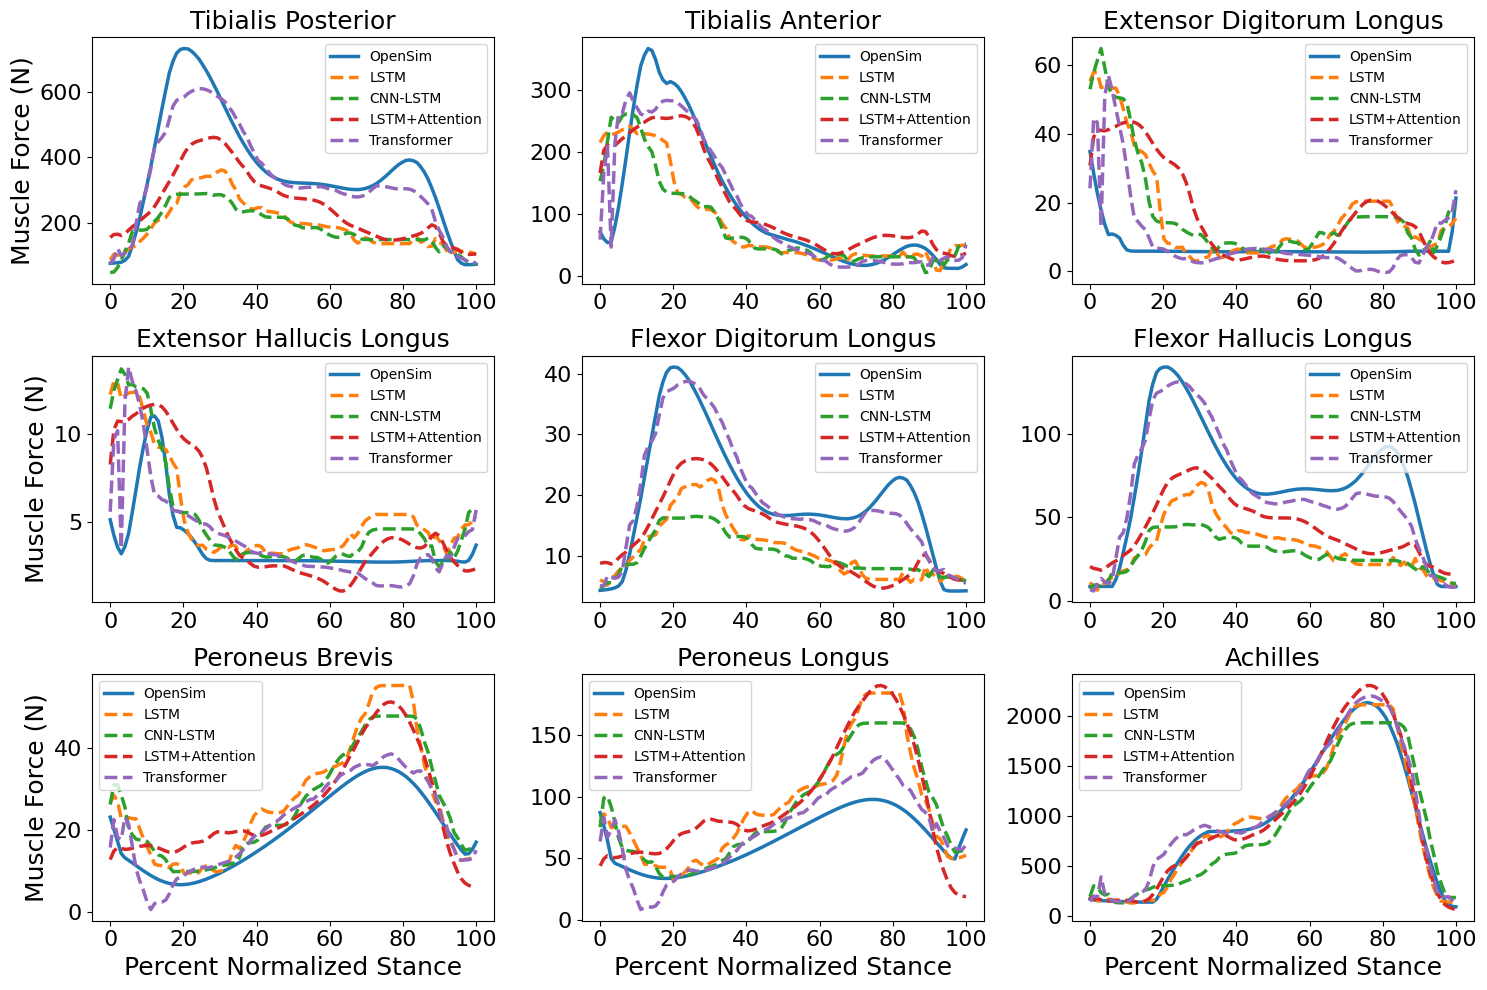

In [46]:
sample_idx = 0

preds = [lstm_pred[sample_idx], cnnlstm_pred[sample_idx], lstmattn_pred[sample_idx], transformer_pred[sample_idx]]
true = y_test[sample_idx]

perc_stance = np.linspace(0, 100, 100)

model_labels = ['LSTM', 'CNN-LSTM', 'LSTM+Attention', 'Transformer']

fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Create subplots for 9 muscles
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(perc_stance, true[:, i], label='OpenSim', linewidth=2.5)
    
    for j, pred in enumerate(preds):
        ax.plot(perc_stance, pred[:, i], label=model_labels[j], linewidth=2.5, linestyle='--')
        
    if i >= 6:
        ax.set_xlabel('Percent Normalized Stance', fontsize=18)
        
    if i % 3 == 0:
        ax.set_ylabel('Muscle Force (N)', fontsize=18)
        
    ax.set_title(muscle_titles[i], fontsize=18)
    if i == 1:
        ax.legend(loc='upper right', fontsize=16, frameon=True)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend()
plt.tight_layout()
plt.show()


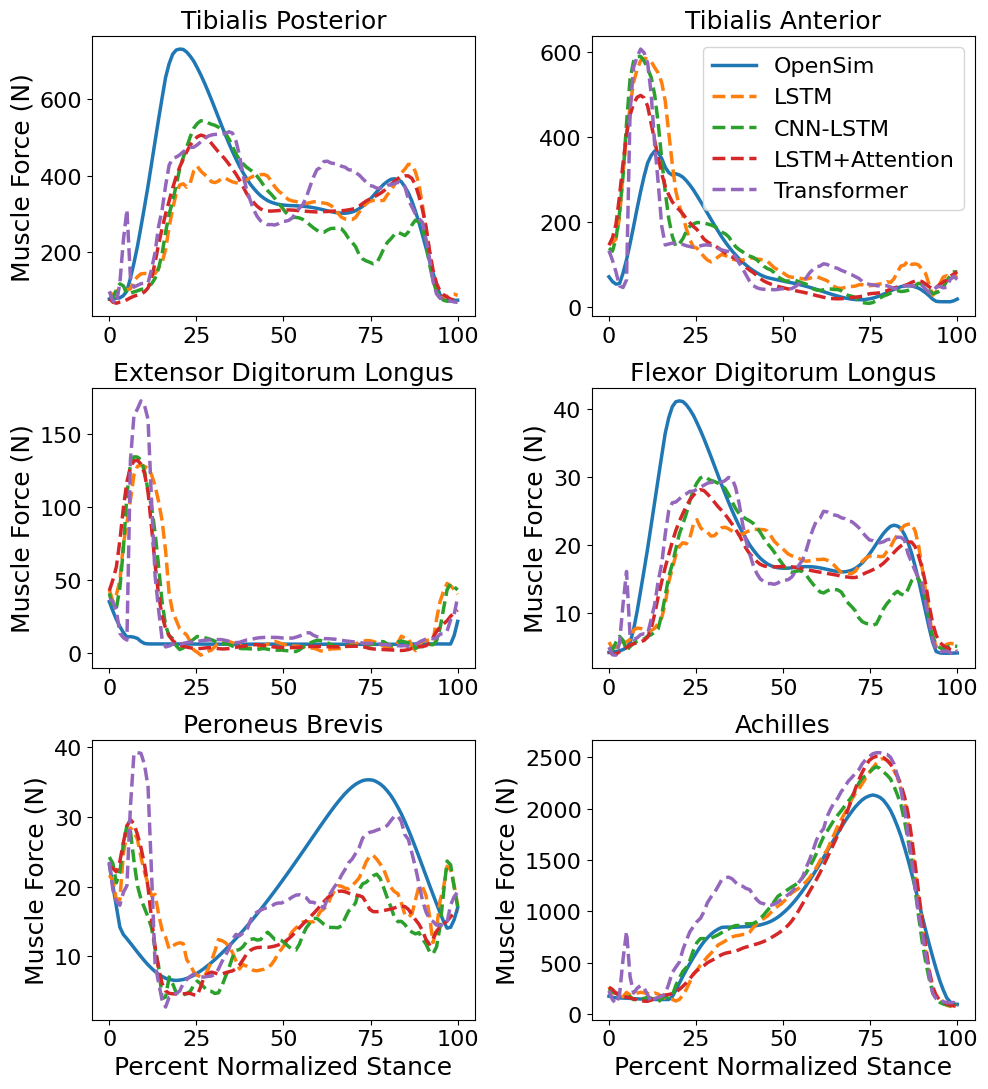

In [81]:
sample_idx = 0

preds = [lstm_pred[sample_idx], cnnlstm_pred[sample_idx], lstmattn_pred[sample_idx], transformer_pred[sample_idx]]
true = y_test[sample_idx]

perc_stance = np.linspace(0, 100, 100)

model_labels = ['LSTM', 'CNN-LSTM', 'LSTM+Attention', 'Transformer']

plot_idx = [0, 1, 2, 4, 6, 8]

fig, axes = plt.subplots(3, 2, figsize=(10, 11))  # Create subplots for 9 muscles
axes = axes.flatten()

for i, ax in zip(plot_idx, axes):
    ax.plot(perc_stance, true[:, i], label='OpenSim', linewidth=2.5)
    
    for j, pred in enumerate(preds):
        ax.plot(perc_stance, pred[:, i], label=model_labels[j], linewidth=2.5, linestyle='--')
        
    if i >= 6:
        ax.set_xlabel('Percent Normalized Stance', fontsize=18)
        
    if i % 2 == 0:
        ax.set_ylabel('Muscle Force (N)', fontsize=18)
        
    ax.set_title(muscle_titles[i], fontsize=18)
    if i == 1:
        ax.legend(loc='upper right', fontsize=16, frameon=True)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.show()


In [37]:
rrmse_muscle_dict = {'LSTM': lstm_rrmse, 'CNN-LSTM': cnnlstm_rrmse, 'LSTM+Attention': lstmattn_rrmse, 'Transformer': transformer_rrmse}
rrmse_overall_dict = {'LSTM': lstm_rrmse_weighted, 'CNN-LSTM': cnnlstm_rrmse_weighted, 'LSTM+Attention': lstmattn_rrmse_weighted, 'Transformer': transformer_rrmse_weighted}

rrmse_table = generate_latex_table(rrmse_muscle_dict, rrmse_overall_dict, muscle_titles)
print(rrmse_table)

\begin{table}
\centering
\begin{tabular}{lcccc}
\toprule
\textbf{Muscle} & \textbf{LSTM} & \textbf{CNN-LSTM} & \textbf{LSTM+Attention} & \textbf{Transformer}\\
\midrule
{Tibialis Posterior} & 0.0430 & 0.0345 & 0.0336 & 0.0342 \\
{Tibialis Anterior} & 0.0251 & 0.0194 & 0.0191 & 0.0190 \\
{Extensor Digitorum Longus} & 0.0195 & 0.0144 & 0.0148 & 0.0121 \\
{Extensor Hallucis Longus} & 0.0067 & 0.0056 & 0.0063 & 0.0057 \\
{Flexor Digitorum Longus} & 0.0114 & 0.0094 & 0.0110 & 0.0096 \\
{Flexor Hallucis Longus} & 0.0214 & 0.0174 & 0.0177 & 0.0174 \\
{Peroneus Brevis} & 0.0112 & 0.0097 & 0.0101 & 0.0095 \\
{Peroneus Longus} & 0.0215 & 0.0182 & 0.0189 & 0.0170 \\
{Achilles} & 0.0149 & 0.0126 & 0.0118 & 0.0130 \\
\midrule
Overall & 0.0207 & 0.0169 & 0.0166 & 0.0167 \\
\bottomrule
\end{tabular}
\caption{Caption}
\label{tab:results}
\end{table}



In [38]:
mae_muscle_dict = {'LSTM': lstm_mae, 'CNN-LSTM': cnnlstm_mae, 'LSTM+Attention': lstmattn_mae, 'Transformer': transformer_mae}
mae_overall_dict = {'LSTM': lstm_mae_weighted, 'CNN-LSTM': cnnlstm_mae_weighted, 'LSTM+Attention': lstmattn_mae_weighted, 'Transformer': transformer_mae_weighted}

mae_table = generate_latex_table(mae_muscle_dict, mae_overall_dict, muscle_titles)
print(mae_table)

\begin{table}
\centering
\begin{tabular}{lcccc}
\toprule
\textbf{Muscle} & \textbf{LSTM} & \textbf{CNN-LSTM} & \textbf{LSTM+Attention} & \textbf{Transformer}\\
\midrule
{Tibialis Posterior} & 41.6380 & 32.5547 & 32.6264 & 32.7998 \\
{Tibialis Anterior} & 18.5041 & 14.2477 & 14.7871 & 14.2274 \\
{Extensor Digitorum Longus} & 4.8785 & 3.5339 & 4.0111 & 3.1329 \\
{Extensor Hallucis Longus} & 0.7742 & 0.6156 & 0.8933 & 0.7072 \\
{Flexor Digitorum Longus} & 2.4214 & 1.9596 & 2.4947 & 2.0666 \\
{Flexor Hallucis Longus} & 10.1040 & 8.1907 & 8.5935 & 8.1351 \\
{Peroneus Brevis} & 3.6214 & 2.9864 & 3.2402 & 2.9945 \\
{Peroneus Longus} & 12.2750 & 9.5677 & 10.1561 & 8.8975 \\
{Achilles} & 45.2614 & 37.4696 & 37.3222 & 40.6598 \\
\midrule
Overall & 0.0137 & 0.0109 & 0.0112 & 0.0112 \\
\bottomrule
\end{tabular}
\caption{Caption}
\label{tab:results}
\end{table}



In [39]:
r2_muscle_dict = {'LSTM': lstm_r2, 'CNN-LSTM': cnnlstm_r2, 'LSTM+Attention': lstmattn_r2, 'Transformer': transformer_r2}
r2_overall_dict = {'LSTM': lstm_r2_overall, 'CNN-LSTM': cnnlstm_r2_overall, 'LSTM+Attention': lstmattn_r2_overall, 'Transformer': transformer_r2_overall}

r2_table = generate_latex_table(r2_muscle_dict, r2_overall_dict, muscle_titles)
print(r2_table)

\begin{table}
\centering
\begin{tabular}{lcccc}
\toprule
\textbf{Muscle} & \textbf{LSTM} & \textbf{CNN-LSTM} & \textbf{LSTM+Attention} & \textbf{Transformer}\\
\midrule
{Tibialis Posterior} & 0.8631 & 0.9123 & 0.9164 & 0.9135 \\
{Tibialis Anterior} & 0.9442 & 0.9667 & 0.9678 & 0.9681 \\
{Extensor Digitorum Longus} & 0.8396 & 0.9124 & 0.9079 & 0.9384 \\
{Extensor Hallucis Longus} & 0.9111 & 0.9379 & 0.9204 & 0.9357 \\
{Flexor Digitorum Longus} & 0.8438 & 0.8935 & 0.8527 & 0.8891 \\
{Flexor Hallucis Longus} & 0.8301 & 0.8868 & 0.8834 & 0.8877 \\
{Peroneus Brevis} & 0.7440 & 0.8101 & 0.7931 & 0.8188 \\
{Peroneus Longus} & 0.6778 & 0.7696 & 0.7526 & 0.7995 \\
{Achilles} & 0.9946 & 0.9961 & 0.9966 & 0.9958 \\
\midrule
Overall & 0.9954 & 0.9969 & 0.9971 & 0.9968 \\
\bottomrule
\end{tabular}
\caption{Caption}
\label{tab:results}
\end{table}



In [40]:
# Settings
muscles = [muscle_abbrevs[i] for i in range(9)]  # Labels for muscles
muscles += ['Overall']  # Add overall R^2
models = list(r2_muscle_dict.keys())
x = np.arange(len(muscles))  # Muscle indices for the x-axis

bar_width = 0.2  # Width of each bar
offsets = np.arange(len(models)) * bar_width  # Offsets for grouped bars

colors = {
    'LSTM': 'C1',
    'CNN-LSTM': 'C2',
    'LSTM+Attention': 'C3',
    'Transformer': 	'C4'
}

for model in models:
    r2_muscle_dict[model] = list(r2_muscle_dict[model])  # Ensure it's a list
    r2_muscle_dict[model].append(r2_overall_dict[model])  # Append overall R^2

    rrmse_muscle_dict[model] = list(rrmse_muscle_dict[model])  # Ensure it's a list
    rrmse_muscle_dict[model].append(rrmse_overall_dict[model])  # Append overall RRMSE



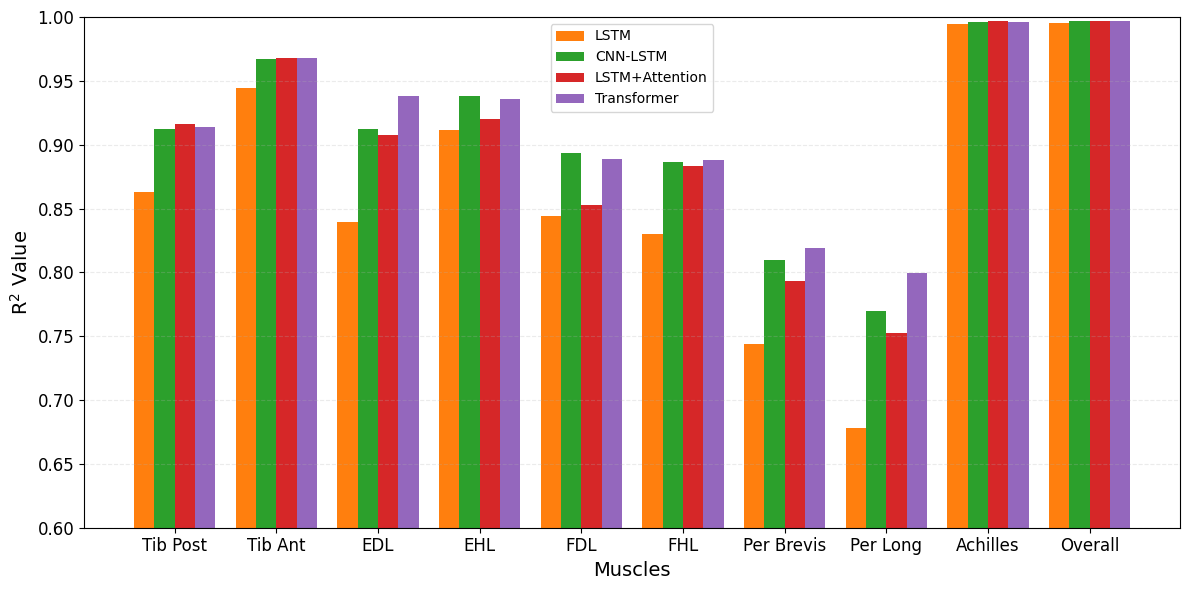

In [41]:
# Plotting
plt.figure(figsize=(12, 6))

for i, model in enumerate(models):
    plt.bar(x + offsets[i], r2_muscle_dict[model], width=bar_width, label=model, color=colors[model])

# Customize plot
plt.xlabel('Muscles', fontsize=14)
plt.ylabel('R$^2$ Value', fontsize=14)
plt.xticks(x + bar_width * (len(models) - 1) / 2, muscles, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.6, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.25)

# Show plot
plt.tight_layout()
plt.show()

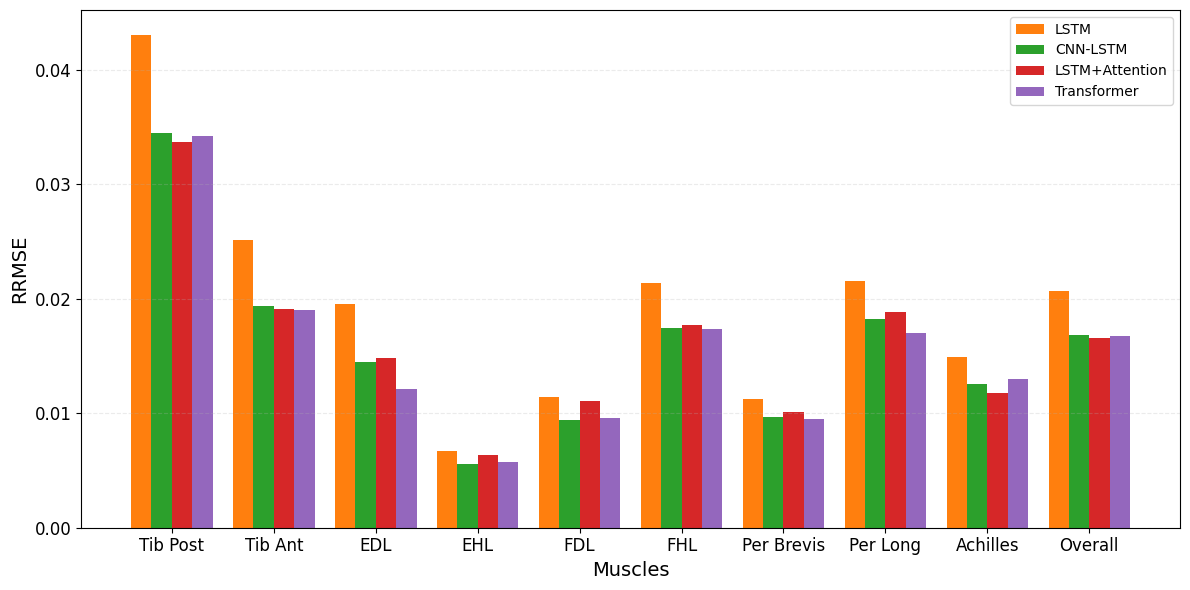

In [42]:
# Plotting
plt.figure(figsize=(12, 6))

for i, model in enumerate(models):
    plt.bar(x + offsets[i], rrmse_muscle_dict[model], width=bar_width, label=model, color=colors[model])

# Customize plot
plt.xlabel('Muscles', fontsize=14)
plt.ylabel('RRMSE', fontsize=14)
plt.xticks(x + bar_width * (len(models) - 1) / 2, muscles, fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim(0.6, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.25)

# Show plot
plt.tight_layout()
plt.show()